**IMPORTS**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import nltk
import re
import os
import string
import json

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**LOAD DATA**

In [3]:
file_path = "./data/IMDB-50k-Dataset.csv"
data = pd.read_csv(file_path)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data['review'].iloc[50], data['sentiment'].iloc[50]

('Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western\'s Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can\'t do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got 

In [5]:
data['review'].iloc[0], data['sentiment'].iloc[0]

("One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

**TEXT CLEANING**

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.strip()



In [7]:
clean_text(data['review'].iloc[50])

'return to the 36th chamber is one of those classic kung fu movies which shaw produces back in the 70s and 80s whose genre is equivalent to the spaghetti westerns of hollywood and the protagonist gordon liu the counterpart to the western s clint eastwood digitally remastered and a new print made for the fantastic film fest this is presented in shaw scope just like the good old days this film is a simple story of good versus evil told in 3 acts which more or less sums up the narrative of martial arts films in that era act one sets up the premise workers in a dye mill of a small village are unhappy with their lot having their wages cut by 20 by incoming manchu gangsters they can t do much about their exploitation because none of them are martial arts skilled to take on the gangsters and their boss at first they had a minor success in getting liu to impersonate a highly skilled shaolin monk one of the best comedy sequences but their rouse got exposed when they pushed the limit of credibil

In [8]:
# Apply text cleaning
data['review'] = data['review'].apply(clean_text)
print(data['review'].head())

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically there s a family where a little boy ...
4    petter mattei s love in the time of money is a...
Name: review, dtype: object


**TOKENIZATION**

In [9]:
vocab = Counter()
for review in data['review']:
    tokens = word_tokenize(review)
    vocab.update(tokens)

N = 5000
vocab = {word: i + 1 for i, (word, _) in enumerate(vocab.most_common(N))}
vocab['<PAD>'] = 0

max_length = 200

In [10]:
# vocab

**X-Y SPLIT**

In [11]:
X = [[vocab.get(word, 0) for word in word_tokenize(review)] for review in data['review']]
X = [review[:max_length] + [vocab['<PAD>']] * (max_length - len(review)) for review in X]
X = np.array(X)
y = (data['sentiment'] == 'positive').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
len(X), len(X[0]), X

(50000,
 200,
 array([[  28,    4,    1, ..., 3106,  152,   21],
        [   3,  393,  120, ...,    0,    0,    0],
        [   9,  192,   10, ...,    0,    0,    0],
        ...,
        [   9,  236,    3, ...,    4,    1, 1374],
        [   9,  140,  168, ...,    8,   10,  417],
        [  56,   28,    0, ...,    0,    0,    0]]))

In [13]:
len(y), y

(50000, array([1, 1, 1, ..., 0, 0, 0]))

**---LOADER---**

In [14]:
class TextReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_dataset = TextReviewDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)


**SENTIMENT MODEL**

In [15]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        h0, _ = self.lstm(x)
        h0 = h0[:, -1, :]
        out = self.fc(h0)
        return self.sigmoid(out)


**PARAMS & MODEL INITIALIZATION**

In [16]:
vocab_size = len(vocab)
embedding_dim = 72
hidden_dim = 128
output_dim = 1
dropout = 0.5
model = SentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 12

**MODEL TRANING**

In [17]:
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f}")


Training Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/12 - Loss: 0.6942
Epoch 2/12 - Loss: 0.5990
Epoch 3/12 - Loss: 0.5268
Epoch 4/12 - Loss: 0.4812
Epoch 5/12 - Loss: 0.4118
Epoch 6/12 - Loss: 0.3790
Epoch 7/12 - Loss: 0.3624
Epoch 8/12 - Loss: 0.3519
Epoch 9/12 - Loss: 0.3367
Epoch 10/12 - Loss: 0.3253
Epoch 11/12 - Loss: 0.3190
Epoch 12/12 - Loss: 0.3125


**EVALUATE MODEL**

Test Accuracy: 86.02%
Test Precision: 87.86%
Test Recall: 83.85%
Test F1 Score: 85.80%
Metrics and confusion matrix saved to model_evaluation.xlsx


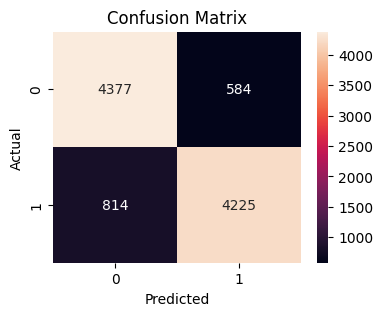

In [18]:
test_dataset = TextReviewDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            predictions = (predictions > 0.5).float()
            y_true.extend(y_batch.numpy())
            y_pred.extend(predictions.numpy())
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Print metrics
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    print(f'Test Recall: {recall * 100:.2f}%')
    print(f'Test F1 Score: {f1 * 100:.2f}%')

    os.makedirs('./evaluation-scores', exist_ok=True)
    # Save the scores to an Excel file
    scores_df = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]})
    scores_df.to_excel('./evaluation-scores/final-evaluation-scores.xlsx', index=False)
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('./evaluation-scores/final-confusion-matrix.png')
    print('Metrics and confusion matrix saved to model_evaluation.xlsx')
    
    return accuracy, precision, recall, f1, conf_matrix

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader)

**SAVE THE MODEL**

In [19]:
os.makedirs('./saved-model', exist_ok=True)

In [20]:
# Save the entire model
torch.save(model, './saved-model/finalized-model.pth')

**LOAD THE SAVED MODEL**

In [21]:
# Load the entire model
loadedmodel = torch.load('./saved-model/finalized-model.pth')


**FUNCTION TO PREDICT FROM LOADED MODEL**

In [22]:
def predict_sentiment(sentence, model, vocab, max_length=200):
    sentence = clean_text(sentence)
    tokens = word_tokenize(sentence)
    token_ids = [vocab.get(token, 0) for token in tokens]
    token_ids = token_ids[:max_length] + [vocab['<PAD>']] * (max_length - len(token_ids))
    token_ids_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        prediction = model(token_ids_tensor).squeeze().item()
    return "positive" if prediction > 0.5 else "negative"


**SENTIMENT PREDICTION**

In [34]:
sentence = "The movie was amazing"
# sentence = "Thank god for karan johar otherwise we would have missed out so many interesting movies"
sentiment = predict_sentiment(sentence, loadedmodel, vocab, max_length)
print(f"The predicted sentiment for the sentence is: {sentiment}")

The predicted sentiment for the sentence is: positive


In [35]:
sentence = "The movie was just average"
# sentence = "Thank god for karan johar otherwise we would have missed out so many interesting movies"
sentiment = predict_sentiment(sentence, loadedmodel, vocab, max_length)
print(f"The predicted sentiment for the sentence is: {sentiment}")

The predicted sentiment for the sentence is: negative
